In [ ]:
This code executes to the end successfully.

In [ ]:
import gym
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [ ]:
print(gym.__version__)

0.26.2


In [ ]:
import sys
assert sys.version_info >= (3, 10)

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB or IS_KAGGLE:
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    %pip install -q -U tf-agents pyvirtualdisplay gym[box2d] atari_py==0.2.6

#Scikit-Learn and TensorFlow version checks
import sklearn
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.15"

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.config.experimental.list_physical_devices('GPU'):
    print("TensorFlow will run on GPU.")
else:
    print("TensorFlow will run on CPU.")

#GPU check
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime type and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

2024-04-06 03:00:03.839389: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 03:00:03.839462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 03:00:03.840103: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-06 03:00:03.845003: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1
TensorFlow will run on GPU.


2024-04-06 03:00:05.061228: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 03:00:05.069635: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 03:00:05.069680: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [ ]:
def write_log(message, log_file="training_log.txt"):
    with open(log_file, "a") as file:
        file.write(message + "\n")

In [1]:
def save_video(frames, path='video.mp4', fps=30):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    fig, ax = plt.subplots()
    ax.set_axis_off()
    ims = [[plt.imshow(frame, animated=True, aspect='auto')] for frame in frames]
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    ani.save(path, writer='ffmpeg', fps=fps)
    plt.close(fig)

# Environment setup

In [ ]:
import gym
env = gym.make("MountainCar-v0", render_mode="rgb_array")
input_shape = env.observation_space.shape
n_outputs = env.action_space.n

# Virtual display for environments that require a GUI

In [ ]:
try:
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900)).start()
except ImportError:
    print("pyvirtualdisplay not available, skipping setup.")

pyvirtualdisplay not available, skipping setup.


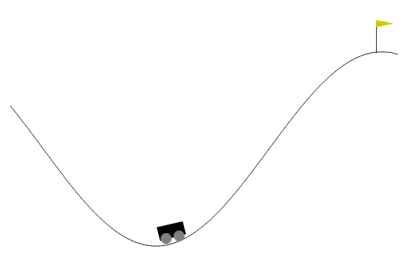

In [ ]:
import matplotlib.pyplot as plt

def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    obs = env.reset(seed=42)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

# DQN implementation

In [ ]:
#Preparing for DQN implementation
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

#Building the DQN model
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", input_shape=input_shape),
    keras.layers.Dense(30, activation="elu"),
    keras.layers.Dense(n_outputs)
])

2024-04-06 03:00:07.016500: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 03:00:07.016584: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 03:00:07.016614: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 03:00:07.147529: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 03:00:07.147586: I external/local_xla/xla/stream_executor

In [ ]:
def epsilon_greedy_policy(state, epsilon):
    if np.random.rand() < epsilon:
        #Exploration, select random action
        return np.random.randint(n_outputs)
    else:
        #This insures state is a numpy array
        #before passing it to model.predict
        if isinstance(state, tuple):
            state = state[0]
        #Exploitation, predict Qvalues using the model
        Q_values = model.predict(state[np.newaxis], verbose=0)
        #Select action with highest Qvalue
        return np.argmax(Q_values[0])

In [3]:
from collections import deque
#Replay memory with a max capacity of 2000 experiences
replay_memory = deque(maxlen=2000)
def sample_experiences(batch_size):
    #Random indices to select experiences from replay memory
    indices = np.random.randint(len(replay_memory), size=batch_size)
    #Get selected experiences from replay memory
    batch = [replay_memory[index] for index in indices]

    #Unpack the experiences into states, actions, rewards, next states, and done flags
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [4]:
def play_one_step(env, state, epsilon, car_max_velocity):
    #Selecting action using epsilon greedy policy
    action = epsilon_greedy_policy(state, epsilon)
    #Take step in environment
    next_state, reward, terminated, info, truncated = env.step(action)
    done = terminated

    #Extract the actual state observation if its wrapped in a tuple
    if isinstance(state, tuple):
        state = state[0]
    if isinstance(next_state, tuple):
        next_state = next_state[0]

    #Checking if we can flatten
    if hasattr(state, 'flatten'):
        state = state.flatten()
    if hasattr(next_state, 'flatten'):
        next_state = next_state.flatten()

    #state[0] is the position of car
    #state[1] is the velocity of car

    #Directional velocity
    current_velocity = next_state[1]
    if abs(current_velocity) > abs(car_max_velocity):
        #Reward bonus for new highest velocity
        reward += 1
        car_max_velocity = current_velocity

    #Reward based on progress and velocity
    #Adding bonus for getting closer to the goal, around position 0.5 in mountain car enviornment
    #Scaling to enhance the effect with positive values only
    progress_bonus = max(0, (next_state[0] - (-0.5)) * 2)
    #Rewarding positive velocity more as it approaches the goal
    velocity_bonus = current_velocity if current_velocity > 0 else 0

    modified_reward = reward + progress_bonus + velocity_bonus

    if done:
        #Large bonus for actually reaching the goal
        modified_reward += 10

    #Store experience in replay memory
    replay_memory.append((state, action, modified_reward, next_state, done))
    return next_state, modified_reward, done, info, car_max_velocity

# Model Hyperparameters

In [ ]:
#During training step, 32 experiences will be sampled from the replay buffer
batch_size = 32
#Importance of future rewards in Qvalue calculation
discount_rate = 0.95
#Learning rate is Step size at which the models parameters are updated
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
#The function that we want to minimise
loss_fn = keras.losses.mean_squared_error

# Training DQN Agent

In [2]:
def training_step(batch_size):
    #Samples batch of experiences from replay buffer
    experiences = sample_experiences(batch_size)
    #Unpacks experiences into separate arrays
    states, actions, rewards, next_states, dones = experiences
    #Predict Qvalues for the next states using model
    next_Q_values = model.predict(next_states, verbose=0)

    #Calculates maximum Q-value for each next state
    max_next_Q_values = np.max(next_Q_values, axis=1)
    #Calculates the target Qvalues using the Bellman equation
    target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values)
    #Reshape target Qvalues to match the shape of model output
    target_Q_values = target_Q_values.reshape(-1, 1)

    #Create mask to select the Qvalues corresponding to taken actions
    mask = tf.one_hot(actions, n_outputs)

    #GradientTape to record the gradients during the forward pass
    with tf.GradientTape() as tape:
        #Compute Qvalues for all actions
        all_Q_values = model(states)
        #Select the Qvalues corresponding to the taken actions using the mask
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        #Calculates mse loss between the target Qvalues and the predicted Qvalues
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    #Calculates gradients of the loss with respect to the models trainable vars
    grads = tape.gradient(loss, model.trainable_variables)

    #Apply gradients to update the models parameters using optimiser
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
from matplotlib import animation
#Variables for tracking best performance and rewards
best_score = -np.inf
rewards = []
epsilons = []
best_weights = None
num_episodes = 500
car_max_velocity = 0

#dictionary to store weights every 100 episodes
saved_weights = {}

write_log("DQN: Starting training...")

for episode in range(num_episodes):
    obs = env.reset()
    episode_reward = 0
    #Initialise new list to store frames for this episode
    frames = []

    #Run for a max of 500 steps per episode
    for step in range(500):
        epsilon = max(1 - episode / num_episodes, 0.01)
        #Capture frame
        frames.append(env.render())
        #Play one step in environment and get the observation, reward, done flag, info, and updated max velocity
        obs, reward, done, info, car_max_velocity = play_one_step(env, obs, epsilon, car_max_velocity)
        episode_reward += reward
        if done:
            break

    #Tracking rewards for each episode
    rewards.append(episode_reward)
    # Tracking epsilon to plot later
    epsilons.append(epsilon)

    if episode_reward > best_score:
        best_score = episode_reward
        #Store weights of the best performing model
        best_weights = model.get_weights()
        save_video(frames, f'DQN_training_videos/episode_{episode}_best_score_{episode_reward:3f}.mp4')
        saved_weights[episode] = model.get_weights()

    #If there is enough experiences in replay memory
    if len(replay_memory) > batch_size:
        #Perform training step
        training_step(batch_size)

    episode_details = f"\rEpisode: {episode}, Reward: {episode_reward}, Best score: {best_score}, Epsilon: {epsilon:.3f}"
    write_log(episode_details)
    print(f"{episode_details}", end="")

if best_weights:
    #Setting model weights to the best performing weights
    model.set_weights(best_weights)

2024-04-06 03:00:32.496389: I external/local_xla/xla/service/service.cc:168] XLA service 0x5598fb62ed20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-06 03:00:32.496425: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2024-04-06 03:00:32.500423: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-06 03:00:32.514302: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1712368832.580853   14494 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episode: 499, Reward: -385.75983347761485, Best score: -72.7384331052308, Epsilon: 0.01024

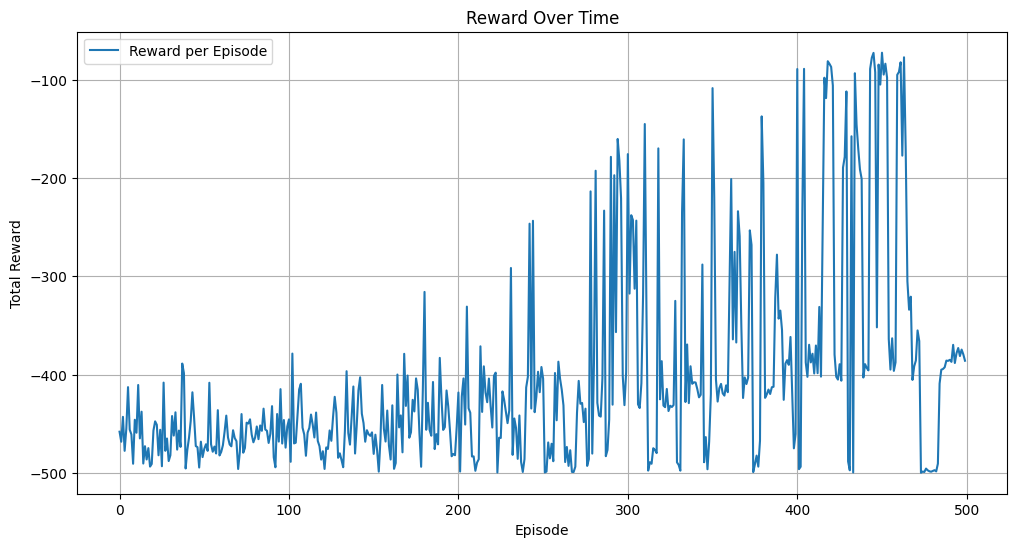

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(rewards, label='Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward Over Time')
plt.legend()
plt.grid(True)
plt.show()

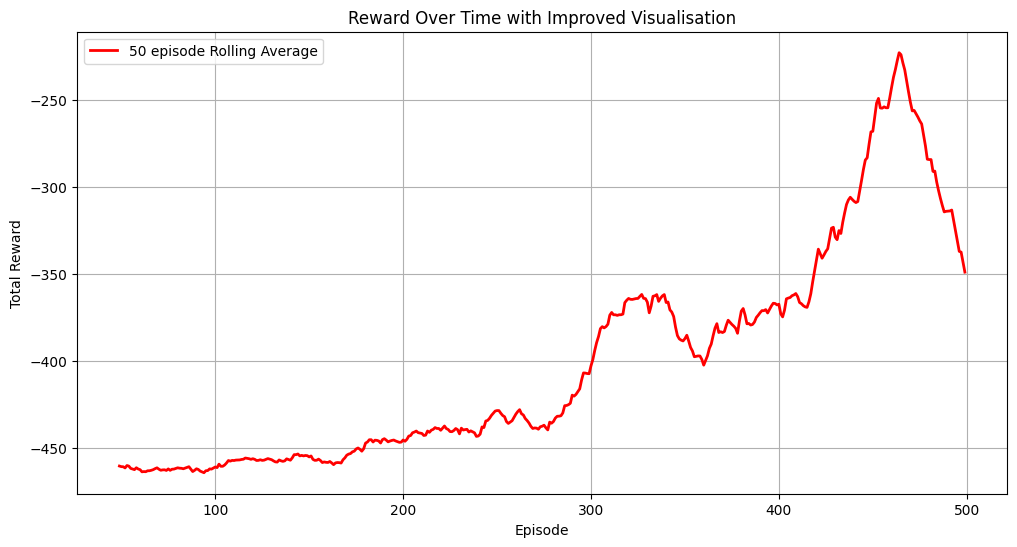

In [ ]:
#Convert the rewards list to a pandas Series for convenience
rewards_series = pd.Series(rewards)

#Calculate the rolling average with a window of the last 10 episodes
rolling_average = rewards_series.rolling(window=50).mean()

#Create a plot with both the raw rewards and the rolling average
plt.figure(figsize=(12, 6))
#plt.plot(rewards, label='Reward per Episode', alpha=0.5)  # Original rewards with some transparency
plt.plot(rolling_average, label='50 episode Rolling Average', color='red', linewidth=2)  # Rolling average in red
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward Over Time with Improved Visualisation')
plt.legend()
plt.grid(True)
plt.show()

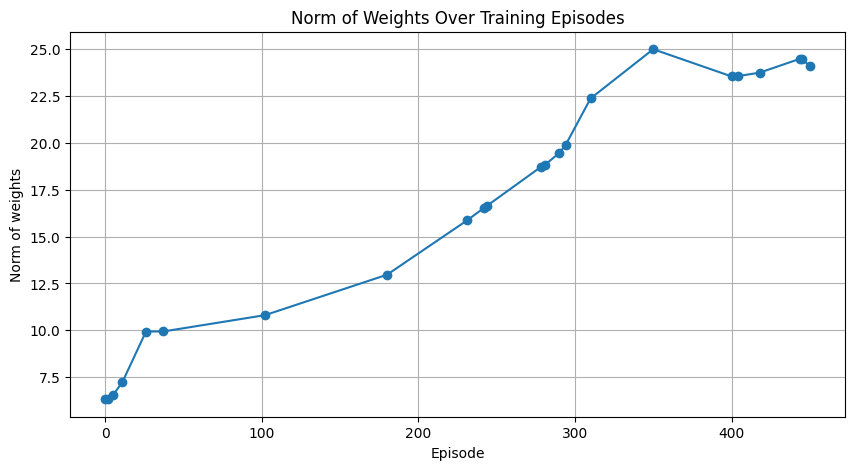

In [ ]:
episodes = list(saved_weights.keys())
weights_norm = [np.linalg.norm(np.concatenate([w.flatten() for w in weights])) for weights in saved_weights.values()]

plt.figure(figsize=(10, 5))
plt.plot(episodes, weights_norm, marker='o')
plt.xlabel('Episode')
plt.ylabel('Norm of weights')
plt.title('Norm of Weights Over Training Episodes')
plt.grid(True)
plt.show()

In [ ]:
def plot_rewards(total_rewards):
    episodes = range(1, len(total_rewards) + 1)

    moving_avg = np.convolve(total_rewards, np.ones(10)/10, mode='valid')  # 10-episode moving average
    rewards_series = pd.Series(total_rewards)

    rolling_average = rewards_series.rolling(window=50).mean()

    plt.figure(figsize=(12, 6))

    #Total Reward per Episode
    plt.subplot(1, 2, 1)
    plt.plot(episodes, total_rewards, marker='o', linestyle='-')
    plt.title('Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(total_rewards, bins=20, kde=True)
    plt.title('Reward Distribution Over Episodes')
    plt.xlabel('Total Reward')
    plt.ylabel('Frequency')
    plt.show()

# Testing DQN Agent

Episode 1: Total Reward = -152.0
Episode 2: Total Reward = -152.0
Episode 3: Total Reward = -142.0
Episode 4: Total Reward = -143.0
Episode 5: Total Reward = -147.0
Episode 6: Total Reward = -141.0
Episode 7: Total Reward = -148.0
Episode 8: Total Reward = -142.0
Episode 9: Total Reward = -139.0
Episode 10: Total Reward = -139.0
Episode 11: Total Reward = -149.0
Episode 12: Total Reward = -139.0
Episode 13: Total Reward = -141.0
Episode 14: Total Reward = -141.0
Episode 15: Total Reward = -139.0
Episode 16: Total Reward = -141.0
Episode 17: Total Reward = -146.0
Episode 18: Total Reward = -138.0
Episode 19: Total Reward = -147.0
Episode 20: Total Reward = -149.0
Episode 21: Total Reward = -141.0
Episode 22: Total Reward = -139.0
Episode 23: Total Reward = -143.0
Episode 24: Total Reward = -139.0
Episode 25: Total Reward = -141.0
Episode 26: Total Reward = -154.0
Episode 27: Total Reward = -155.0
Episode 28: Total Reward = -146.0
Episode 29: Total Reward = -141.0
Episode 30: Total Rewar

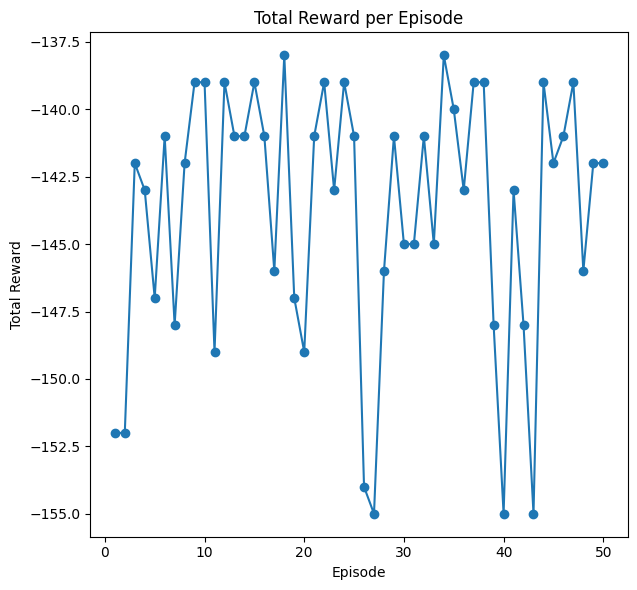

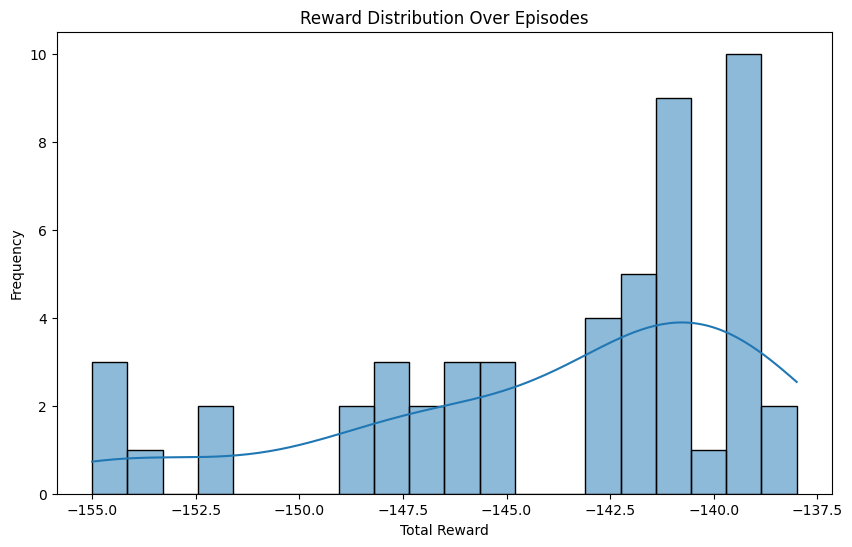

In [ ]:
def test_agent(env, model, n_episodes=50):
    total_rewards = []
    for episode in range(n_episodes):
        #Reset the environment and get the initial state
        state_tuple = env.reset()
        #Insure state is the actual observation array, not a tuple
        state = state_tuple if not isinstance(state_tuple, tuple) else state_tuple[0]
        done = False
        total_reward = 0
        while not done:
            #Prepare state for model prediction
            q_values = model.predict(state[np.newaxis], verbose=0)
            #Choose the best action based on the model's prediction
            action = np.argmax(q_values[0])
            #Perform the action
            outcomes = env.step(action)
            #Correctly handle different lengths of returned values
            state_tuple, reward, done, _ = outcomes if len(outcomes) == 4 else (outcomes[0], outcomes[1], outcomes[2], {})
            #Update state with the new state
            state = state_tuple if not isinstance(state_tuple, tuple) else state_tuple[0]
            total_reward += reward
        total_rewards.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    print(f"Average Total Reward over {n_episodes} episodes: {np.mean(total_rewards)}")
    plot_rewards(total_rewards)

test_agent(env, model)

# DDQN Implementation

In [ ]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", input_shape=input_shape),
    keras.layers.Dense(30, activation="elu"),
    keras.layers.Dense(n_outputs)
])

#Cloning the model to create a target model
target_model = keras.models.clone_model(model)
target_model.set_weights(model.get_weights())

# DDQN Training

In [ ]:
def DDQN_training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences

    #Use the main model to select the best action for the next states
    next_actions = np.argmax(model.predict(next_states, verbose=0), axis=1)

    #Use the target model to calculate the Q values for the best actions
    #in the next states as chosen by the main model
    next_Q_values = target_model.predict(next_states, verbose=0)[np.arange(batch_size), next_actions]

    #Calculate target Q values
    target_Q_values = rewards + (1 - dones) * discount_rate * next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)

    #Update main model
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * tf.one_hot(actions, n_outputs), axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
#Variables for tracking best performance and rewards
best_score = -np.inf
rewards = []
epsilons = []
best_weights = None
num_episodes = 500
car_max_velocity = 0

#dictionary to store weights every 100 episodes
saved_weights = {}

write_log("Starting training DDQN...")
for episode in range(num_episodes):
    obs = env.reset()
    episode_reward = 0
    #Initialise new list to store frames for this episode
    frames = []

    for step in range(500):
        epsilon = max(1 - episode / num_episodes, 0.01)
        #Capture frame
        frames.append(env.render())
        #Play one step in environment and get the observation, reward, done flag, info, and updated max velocity
        obs, reward, done, info, car_max_velocity = play_one_step(env, obs, epsilon, car_max_velocity)
        episode_reward += reward
        if done:
            break

    #Tracking rewards for each episode
    rewards.append(episode_reward)
    # Tracking epsilon to plot later
    epsilons.append(epsilon)

    if episode_reward > best_score:
        best_score = episode_reward
        best_weights = model.get_weights()
        save_video(frames,
                       f'ep_{episode}_score_{episode_reward:3f}.mp4')
        saved_weights[episode] = model.get_weights()

    if len(replay_memory) > batch_size:
        DDQN_training_step(batch_size)

    #Frequency to update the model
    if episode % 20 == 0:
        target_model.set_weights(model.get_weights())

    episode_details = f"\rEpisode: {episode}, Reward: {episode_reward}, Best score: {best_score}, Epsilon: {epsilon:.3f}"
    write_log(episode_details)
    print(f"{episode_details}", end="")

if best_weights:
    model.set_weights(best_weights)

Episode: 499, Reward: -379.1477484262432, Best score: -74.00544688229274, Epsilon: 0.01004

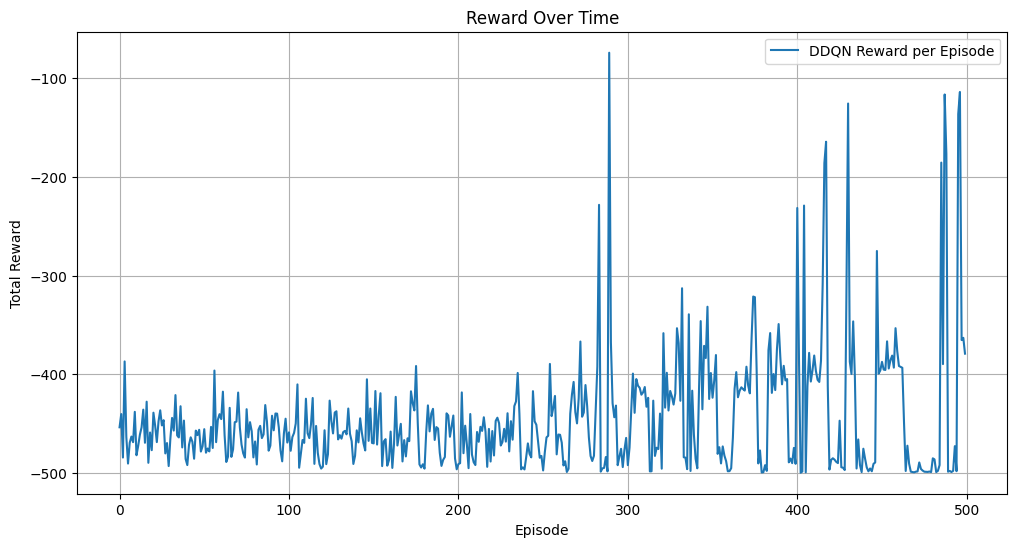

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(rewards, label='DDQN Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward Over Time')
plt.legend()
plt.grid(True)
plt.show()

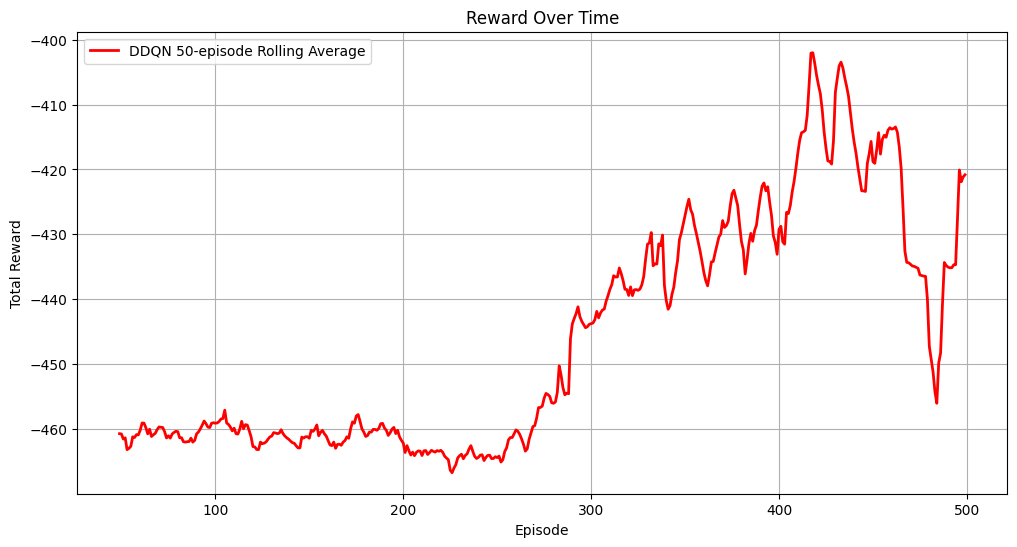

In [ ]:
#Converting rewards list to a pandas Series for convenience
rewards_series = pd.Series(rewards)
#Calculate the rolling average with a window of the last 50 episodes
rolling_average = rewards_series.rolling(window=50).mean()

#Raw rewards and the rolling average
plt.figure(figsize=(12, 6))
#plt.plot(rewards, label='Reward per Episode', alpha=0.5)  # Original rewards with some transparency
plt.plot(rolling_average, label='DDQN 50-episode Rolling Average', color='red', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Testing DDQN Agent

Episode 1: Total Reward = -162.0
Episode 2: Total Reward = -171.0
Episode 3: Total Reward = -160.0
Episode 4: Total Reward = -157.0
Episode 5: Total Reward = -160.0
Episode 6: Total Reward = -178.0
Episode 7: Total Reward = -158.0
Episode 8: Total Reward = -158.0
Episode 9: Total Reward = -170.0
Episode 10: Total Reward = -159.0
Episode 11: Total Reward = -157.0
Episode 12: Total Reward = -157.0
Episode 13: Total Reward = -158.0
Episode 14: Total Reward = -159.0
Episode 15: Total Reward = -177.0
Episode 16: Total Reward = -163.0
Episode 17: Total Reward = -165.0
Episode 18: Total Reward = -171.0
Episode 19: Total Reward = -158.0
Episode 20: Total Reward = -158.0
Episode 21: Total Reward = -175.0
Episode 22: Total Reward = -156.0
Episode 23: Total Reward = -169.0
Episode 24: Total Reward = -171.0
Episode 25: Total Reward = -158.0
Episode 26: Total Reward = -160.0
Episode 27: Total Reward = -157.0
Episode 28: Total Reward = -158.0
Episode 29: Total Reward = -160.0
Episode 30: Total Rewar

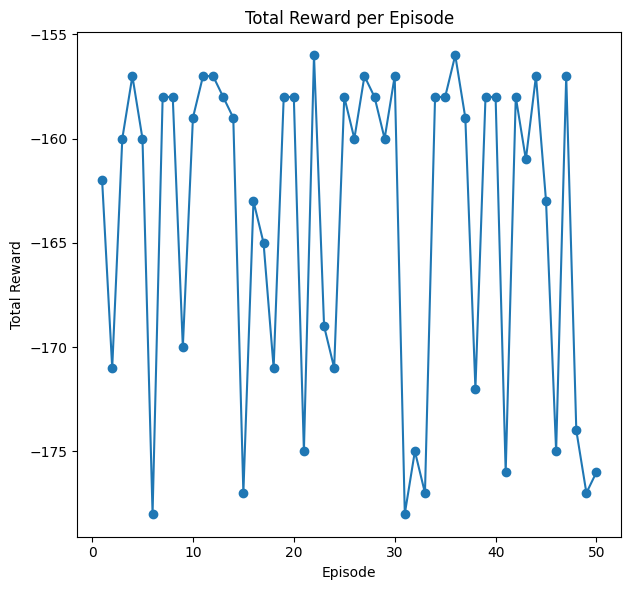

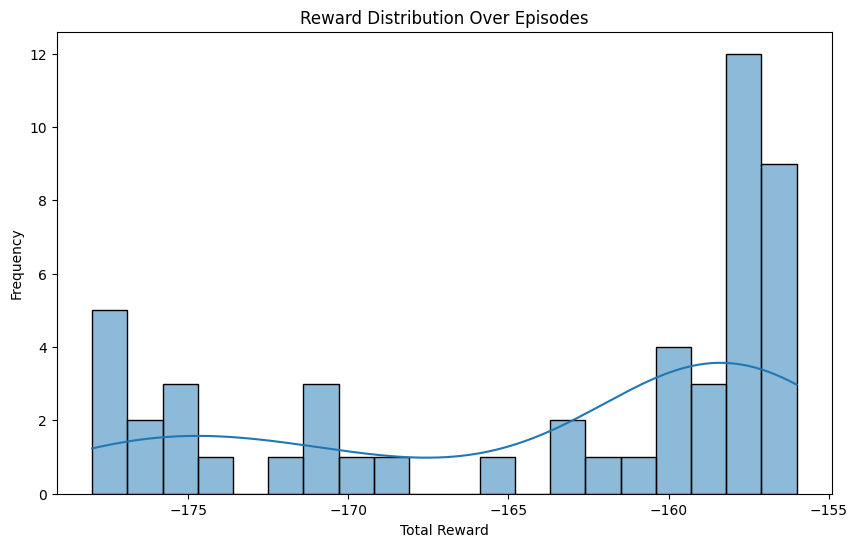

In [ ]:
def test_agent(env, model, n_episodes=50):
    total_rewards = []
    for episode in range(n_episodes):
        #Reset the environment and get the initial state
        state_tuple = env.reset()

        state = state_tuple if not isinstance(state_tuple, tuple) else state_tuple[0]
        done = False
        total_reward = 0
        while not done:
            #Preparing state for model prediction
            q_values = model.predict(state[np.newaxis], verbose=0)
            #Choosing best action based on the model prediction
            action = np.argmax(q_values[0])
            #Perform action
            outcomes = env.step(action)
            #Handle different lengths of returned values
            state_tuple, reward, done, _ = outcomes if len(outcomes) == 4 else (outcomes[0], outcomes[1], outcomes[2], {})
            #Update state with new state
            state = state_tuple if not isinstance(state_tuple, tuple) else state_tuple[0]
            total_reward += reward

        total_rewards.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")

    print(f"Average Total Reward over {n_episodes} episodes: {np.mean(total_rewards)}")
    plot_rewards(total_rewards)

test_agent(env, model)